In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.units as u
from asteria.stellardist import StellarDensity
from scipy.interpolate import PchipInterpolator
from scipy.optimize import minimize

In [2]:
def diff(x, r):
    diff = np.abs(Dist2Rate(x) - r)
    return float(diff)

def Dist2Rate(d):
    return sd_ccsn_rate(d)

def Rate2Dist(r_in):
    if not isinstance(r_in, np.ndarray):
        if r_in > sd_ccsn_tot_rate:
            r_in = sd_ccsn_tot_rate
        res = minimize(diff, x0=10, args=r_in)
        return res.x
    else:
        np.where(r_in>sd_ccsn_tot_rate,sd_ccsn_tot_rate,r_in)
        r_out = []
        for rr in r_in:
            res = minimize(diff, x0=10, args=rr)
            r_out.append(res.x)
        r_out = np.array(r_out)
        return r_out
    
def diff_cdf(x, cdf_val):
    if x > 25 + 1E-3: #everything above 25 kpc has a probability of 100%, but we want the 'edge' so we punish any
        # value that is higher than 25 kpc + epsilon, epsilon << 1
        return 1E6
    else:
        diff = np.abs(sd_cdf(x) - cdf_val)
        return float(diff)
    
def inv_cdf(cdf_val):
    if not isinstance(cdf_val, np.ndarray):
        res = minimize(diff_cdf, x0 = 5, args=cv)
        return res.x
    else:
        d = []
        for cv in cdf_val:
            loss, i = 1, 0
            x0s = np.array([5,10,15,20])
            while loss > 1E-3:
                res = minimize(diff_cdf, x0 = x0s[i], args=cv)
                loss = res.fun
                i += 1
                if i > 3:
                    print('Fit failed to converge!')
                    break
            d.append(res.x)
        d = np.array(d)
        return d
    
def MSE(v):
    return np.sqrt(np.sum((func(v)-sig)**2))

In [3]:
def get_simparam(index):
    dt = 1 * u.ms

    #default settings
    include_wls = False #"False", "True"

    stime = "wide" # "dep", "indep"
    sfreq = 0 * u.Hz # "dep", "indep"

    smix = "NoTransformation" # "NoTransformation", "CompleteExchange", "AdiabaticMSW"
    shier = "normal" # "normal", "inverted"
    smodel = "Tamborra_2014_20M" # "Tamborra_2014_20M", "Tamborra_2014_27M"
    sdir = 1

    if index == 1:
        stime = "narrow"

    elif index == 2:
        sfreq = 10 * u.Hz

    elif index == 3:
        sfreq = -10 * u.Hz

    elif index == 4:
        smix = "CompleteExchange"

    elif index == 5:
        smix = "AdiabaticMSW"

    elif index == 6:
        smix = "AdiabaticMSW"
        shier = "inverted"

    elif index == 7:
        smodel = "Tamborra_2014_27M"
        sdir = 1  

    elif index == 8:
        smodel = "Tamborra_2014_27M"
        sdir = 2  

    elif index == 9:
        smodel = "Tamborra_2014_27M"
        sdir = 3  
    
    return smodel, sdir, smix, shier, stime, sfreq

In [4]:
# stellar distribution file, Adams 2013 model, returns CDF
sd = StellarDensity('../../../../data/stellar/sn_radial_distrib_adams.fits', add_LMC=False, add_SMC=False)
sd_cdf = PchipInterpolator(sd.dist.value, sd.cdf)

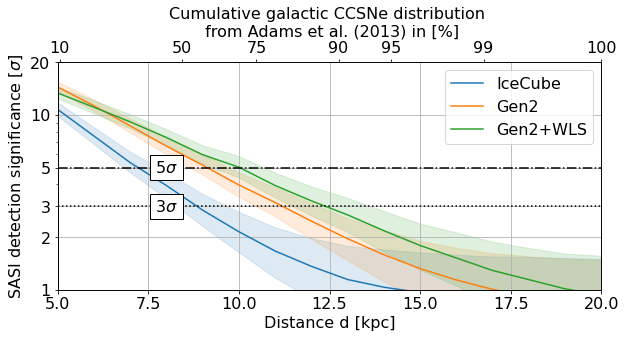

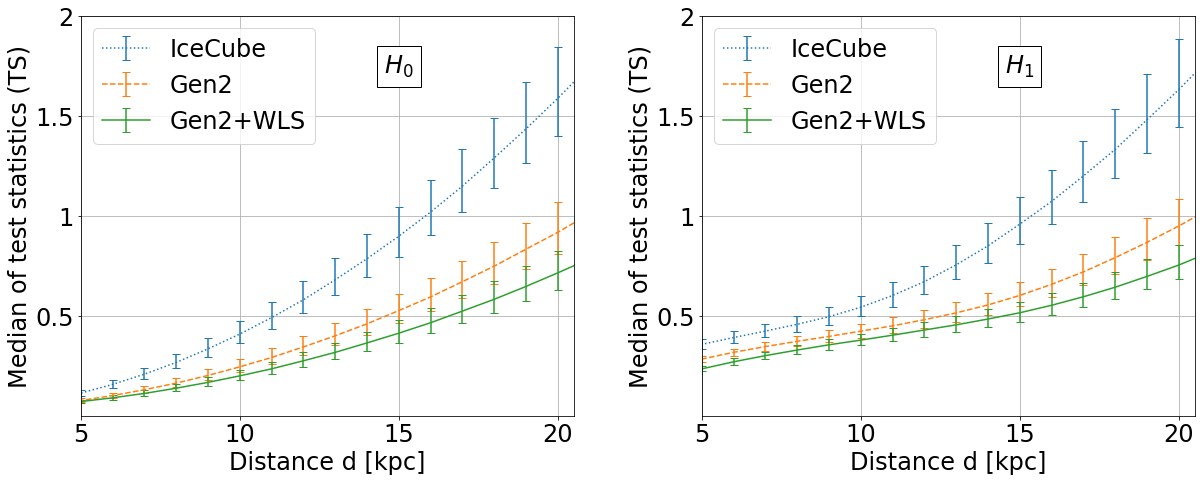

In [6]:
# get simulation parameters
smodel, sdir, smix, shier, stime, sfreq = get_simparam(0)

# load data
filename1 = './files/ampl_'+smodel+'_dir='+str(sdir)+'_mix='+smix+'_hierarchy='+shier+'_time'+stime+'_freq_{}_Hz'.format(sfreq.value)+'_IC86+Gen2.pkl'
filename2 = './files/ampl_'+smodel+'_dir='+str(sdir)+'_mix='+smix+'_hierarchy='+shier+'_time'+stime+'_freq_{}_Hz'.format(sfreq.value)+'_IC86+Gen2+WLS.pkl'

file1 = open(filename1, 'rb')
data1 = pickle.load(file1)
file2 = open(filename2, 'rb')
data2 = pickle.load(file2)

# unpack data
distances, Sts_gen2, Sts_ic86, Bts_gen2, Bts_ic86, Z_gen2, Z_ic86 = data1
distances, Sts_wls, Sts_ic86, Bts_wls, Bts_ic86, Z_wls, Z_ic86 = data2

# plot significance vs distance for default setting
fig, ax = plt.subplots(1,1, figsize = (10,6))
font = {'size'   : 50}

mpl.rc('font', **font)

ax.plot(distances, Z_ic86.T[0], color = 'C0', label=r'IceCube')
ax.plot(distances, Z_gen2.T[0], color = 'C1', label=r'Gen2')
ax.plot(distances, Z_wls.T[0], color = 'C2', label=r'Gen2+WLS')

ax.fill_between(distances.value, Z_ic86.T[2], Z_ic86.T[1], alpha = 0.15, color = 'C0')
ax.fill_between(distances.value, Z_gen2.T[2], Z_gen2.T[1], alpha = 0.15, color = 'C1')
ax.fill_between(distances.value, Z_wls.T[2], Z_wls.T[1], alpha = 0.15, color = 'C2')

ax.set_xlabel('Distance d [kpc]', fontsize = 16)
ax.set_ylabel(r'SASI detection significance [$\sigma$]' , fontsize = 16)
ax.set_xlim((5,20))
ax.set_ylim((1,20))

ax.tick_params(labelsize = 16)

ax.set_xticks([5,7.5,10,12.5,15,17.5,20])

ax.set_yscale('log')
ax.set_yticks([1,2,3,5,10,20])
ax.set_yticklabels(['1','2','3','5','10','20'])

ax.grid()
ax.legend(loc='upper right', fontsize = 16)

ax.axhline(3, color='k', ls = ':')
ax.axhline(5, color='k', ls = '-.')
ax.text(8, 3, r"3$\sigma$", size=16,
         ha="center", va="center",
         bbox=dict(boxstyle="square", ec='k', fc='white'))

ax.text(8, 5, r"5$\sigma$", size=16,
         ha="center", va="center",
         bbox=dict(boxstyle="square", ec='k', fc='white'))

rates = np.array([0.1,0.5,0.75,0.9,0.95,0.99,1])
ax22 = ax.twiny()
ax22.set_xlim(ax.get_xlim())
ax22.set_xticks(inv_cdf(rates).flatten())
ax22.set_xticklabels((rates*100).astype(dtype=int), rotation = 0, fontsize = 16)
ax22.set_xlabel('Cumulative galactic CCSNe distribution \n from Adams et al. (2013) in [%]', fontsize = 16)

plt.tight_layout()
plt.savefig('../plots/ftf_ampl_results.pdf', dpi = 200, facecolor = 'white')


# plot TS distribution of default setting
fig, ax = plt.subplots(1,2, figsize = (18,8))

#background with errorbar
ax[0].errorbar(x=distances, y=Bts_ic86.T[0],yerr=(Bts_ic86.T[0]-Bts_ic86.T[1],Bts_ic86.T[2]-Bts_ic86.T[0]), 
               capsize=4, color = 'C0', ls = ':', label='IceCube')
ax[0].errorbar(x=distances, y=Bts_gen2.T[0],yerr=(Bts_gen2.T[0]-Bts_gen2.T[1],Bts_gen2.T[2]-Bts_gen2.T[0]), 
               capsize=4, color = 'C1', ls = '--', label='Gen2')
ax[0].errorbar(x=distances, y=Bts_wls.T[0],yerr=(Bts_wls.T[0]-Bts_wls.T[1],Bts_wls.T[2]-Bts_wls.T[0]), 
               capsize=4, color = 'C2', ls = '-', label='Gen2+WLS')
ax[0].text(15, 1.75, r"$H_0$", size=24,
         ha="center", va="center",
         bbox=dict(boxstyle="square", ec='k', fc='white', alpha = 1), zorder = 30)


#signal without errorbar

ax[1].errorbar(x=distances, y=Sts_ic86.T[0],yerr=(Sts_ic86.T[0]-Sts_ic86.T[1],Sts_ic86.T[2]-Sts_ic86.T[0]), 
               capsize=4, color = 'C0', ls = ':', label='IceCube')
ax[1].errorbar(x=distances, y=Sts_gen2.T[0],yerr=(Sts_gen2.T[0]-Sts_gen2.T[1],Sts_gen2.T[2]-Sts_gen2.T[0]), 
               capsize=4, color = 'C1', ls = '--', label='Gen2')
ax[1].errorbar(x=distances, y=Sts_wls.T[0],yerr=(Sts_wls.T[0]-Sts_wls.T[1],Sts_wls.T[2]-Sts_wls.T[0]), 
               capsize=4, color = 'C2', ls = '-', label='Gen2+WLS')
ax[1].text(15, 1.75, r"$H_1$", size=24,
         ha="center", va="center",
         bbox=dict(boxstyle="square", ec='k', fc='white', alpha = 1), zorder = 30)

for i in range(2):
    ax[i].set_xlabel('Distance d [kpc]', fontsize = 24)
    ax[i].set_ylabel('Median of test statistics (TS)', fontsize = 24)
    ax[i].set_xlim((5,20.5))
    ax[i].set_ylim((0,2))
    ax[i].set_yticks([0.5,1,1.5,2])
    ax[i].set_yticklabels(['0.5','1','1.5','2'])


    #ax[i].set_yscale('log')
    ax[i].tick_params(labelsize = 24)
    ax[i].legend(fontsize = 24, loc = 'upper left')
    ax[i].grid()
plt.tight_layout()
plt.savefig('../plots/ftf_ampl_tsdistance.pdf', dpi = 200, facecolor = 'white')

In [8]:
sfreq

<Quantity 0. Hz>

In [18]:
for i in range(10):
    dt = 1 * u.ms

    # get simulation parameters
    smodel, sdir, smix, shier, stime, sfreq = get_simparam(i)
    
    # load data
    filename1 = './files/ampl_'+smodel+'_dir='+str(sdir)+'_mix='+smix+'_hierarchy='+shier+'_time'+stime+'_freq_{}_Hz'.format(sfreq.value)+'_IC86+Gen2.pkl'
    filename2 = './files/ampl_'+smodel+'_dir='+str(sdir)+'_mix='+smix+'_hierarchy='+shier+'_time'+stime+'_freq_{}_Hz'.format(sfreq.value)+'_IC86+Gen2+WLS.pkl'

    file1 = open(filename1, 'rb')
    data1 = pickle.load(file1)
    file2 = open(filename2, 'rb')
    data2 = pickle.load(file2)

    # unpack data
    distances, Sts_gen2, Sts_ic86, Bts_gen2, Bts_ic86, Z_gen2, Z_ic86 = data1
    distances, Sts_wls, Sts_ic86, Bts_wls, Bts_ic86, Z_wls, Z_ic86 = data2
    
    d_min = 4*u.kpc
    # cutoff distance for interpolation, inf values need to be excluded
    d_wls = distances[np.logical_and(distances>d_min, np.where(np.isinf(Z_wls.T[-1])==True, 0, 1))][0]
    d_gen2 = distances[np.logical_and(distances>d_min, np.where(np.isinf(Z_gen2.T[-1])==True, 0, 1))][0]
    d_ic86 = distances[np.logical_and(distances>d_min, np.where(np.isinf(Z_ic86.T[-1])==True, 0, 1))][0]

    sig_wls_50 = PchipInterpolator(distances[distances>d_wls], Z_wls[distances>d_wls].T[0])
    sig_gen2_50 = PchipInterpolator(distances[distances>d_gen2], Z_gen2[distances>d_gen2].T[0])
    sig_ic86_50 = PchipInterpolator(distances[distances>d_ic86], Z_ic86[distances>d_ic86].T[0])

    sig_wls_14 = PchipInterpolator(distances[distances>d_wls], Z_wls[distances>d_wls].T[1])
    sig_gen2_14 = PchipInterpolator(distances[distances>d_gen2], Z_gen2[distances>d_gen2].T[1])
    sig_ic86_14 = PchipInterpolator(distances[distances>d_ic86], Z_ic86[distances>d_ic86].T[1])

    sig_wls_86 = PchipInterpolator(distances[distances>d_wls], Z_wls[distances>d_wls].T[2])
    sig_gen2_86 = PchipInterpolator(distances[distances>d_gen2], Z_gen2[distances>d_gen2].T[2])
    sig_ic86_86 = PchipInterpolator(distances[distances>d_ic86], Z_ic86[distances>d_ic86].T[2])

    sd_ccsn = PchipInterpolator(sd.dist.value, sd.cdf)

    # plots TS and significance
    if 0:
        fig, ax = plt.subplots(1,2, figsize = (16,6))
        ax = ax.ravel()

        ax[0].plot(distances, Z_ic86.T[0], color = 'C0', label=r'$IceCube$')
        ax[0].plot(distances, Z_gen2.T[0], color = 'C1', label=r'$Gen2$')
        ax[0].plot(distances, Z_wls.T[0], color = 'C2', label=r'$Gen2+WLS$')

        ax[0].fill_between(distances.value, Z_ic86.T[2], Z_ic86.T[1], alpha = 0.15, color = 'C0')
        ax[0].fill_between(distances.value, Z_gen2.T[2], Z_gen2.T[1], alpha = 0.15, color = 'C1')
        ax[0].fill_between(distances.value, Z_wls.T[2], Z_wls.T[1], alpha = 0.15, color = 'C2')

        ax[0].set_xlabel('Distance d [kpc]', fontsize = 12)
        ax[0].set_ylabel(r'SASI detection significance [$\sigma$]' , fontsize = 12)
        ax[0].set_xlim((1,40))
        ax[0].set_ylim((1,30))

        ax[0].tick_params(labelsize = 12)

        ax[0].set_yscale('log')
        ax[0].set_yticks([1,2,3,5,10,20,30])
        ax[0].set_yticklabels(['1','2','3','5','10','20','30'])

        ax[0].grid()
        ax[0].legend(loc='upper right', fontsize = 12)

        ax[0].axhline(3, color='k', ls = ':')
        ax[0].axhline(5, color='k', ls = '-.')
        ax[0].text(8, 3, r"3$\sigma$", size=12,
                 ha="center", va="center",
                 bbox=dict(boxstyle="square", ec='k', fc='white'))

        ax[0].text(8, 5, r"5$\sigma$", size=12,
                 ha="center", va="center",
                 bbox=dict(boxstyle="square", ec='k', fc='white'))

        rates = np.array([0.1,0.5,0.75,0.9,0.95,0.99,1])
        ax22 = ax[0].twiny()
        ax22.set_xlim(ax[0].get_xlim())
        ax22.set_xticks(inv_cdf(rates).flatten())
        ax22.set_xticklabels((rates*100).astype(dtype=int), rotation = 0, fontsize = 12)
        ax22.set_xlabel('Cumulative galactic CCSNe distribution \n from Adams et al. (2013) in [%]', fontsize = 12)

        #signal without errorbar
        ax[1].plot(distances, Sts_ic86.T[0], color = 'C0', label=r'TS$^{sig}_{IceCube}$')
        ax[1].plot(distances, Sts_gen2.T[0], color = 'C1', label=r'TS$^{sig}_{Gen2}$')
        ax[1].plot(distances, Sts_wls.T[0], color = 'C2', label=r'TS$^{sig}_{Gen2+WLS}$')

        #background with errorbar
        ax[1].errorbar(x=distances, y=Bts_ic86.T[0],yerr=(Bts_ic86.T[0]-Bts_ic86.T[1],Bts_ic86.T[2]-Bts_ic86.T[0]), 
                       capsize=4, color = 'C0', ls = ':', label=r'TS$^{bkg}_{IceCube}$')
        ax[1].errorbar(x=distances, y=Bts_gen2.T[0],yerr=(Bts_gen2.T[0]-Bts_gen2.T[1],Bts_gen2.T[2]-Bts_gen2.T[0]), 
                       capsize=4, color = 'C1', ls = ':', label=r'TS$^{bkg}_{Gen2}$')
        ax[1].errorbar(x=distances, y=Bts_wls.T[0],yerr=(Bts_wls.T[0]-Bts_wls.T[1],Bts_wls.T[2]-Bts_wls.T[0]), 
                       capsize=4, color = 'C2', ls = ':', label=r'TS$^{bkg}_{Gen2+WLS}$')

        #rearrange legend handels
        handles,labels = ax[1].get_legend_handles_labels()

        handles = [handles[0], handles[3], handles[1], handles[4], handles[2], handles[5]]
        labels = [labels[0], labels[3], labels[1], labels[4], labels[2], labels[5]]


        ax[1].set_xlabel('Distance d [kpc]', fontsize = 12)
        ax[1].set_ylabel('Median of test statistics (TS)', fontsize = 12)
        ax[1].set_xlim((1,40))
        ax[1].set_yscale('log')
        ax[1].tick_params(labelsize = 12)
        ax[1].legend(handles, labels, ncol = 3, fontsize = 12, bbox_to_anchor=(0.13, 1))
        ax[1].grid()

        plt.tight_layout()

        filename = './plots/ampl_'+smodel+'_dir='+str(sdir)+'_mix='+smix+'_hierarchy='+shier+'_time'+stime+'_freq_{}_Hz'.format(sfreq.value)+'_IC86+Gen2+WLS.png'
        plt.savefig(filename, dpi = 200, facecolor = 'white')
        
    #prints values for LaTeX label
    if 1:
        prefix = ['\makecell{\SI{50}{\ms} $ < t < $ \SI{313}{\ms}\\\ No Transformation\\\\SI{20}{\solarmass}} & ', 
                  '\SI{150}{\ms} $ < t < $ \SI{300}{\ms} & ',
                  '\makecell{$f_{\text{SASI}}\  + $ \SI{10}{\Hz}\\\$\Delta t_{\text{max diff}}=$\SI{11}{\milli \s}} &',
                  '\makecell{$f_{\text{SASI}}\  - $ \SI{10}{\Hz}\\\$\Delta t_{\text{max diff}}=$\SI{14}{\milli \s}} & ',
                  'Complete Exchange & ',
                  'Adiabatic MSW NH & ',
                  'Adiabatic MSW IH & ',
                  '\SI{27}{\solarmass} $d_1$ & ',
                  '\SI{27}{\solarmass} $d_2$ & ',
                  '\SI{27}{\solarmass} $d_3$ & ',
                  ]
        midfix = '\makecell{$3 \sigma$\\\[2mm]$5 \sigma$} & '
        filename = './latex_ampl.txt' 
        
        if i == 0:
            open(filename, 'w').close()
            
        with open(filename, 'a') as f:
            print(prefix[i] + midfix, file = f)
            for det in ["ic86", "gen2", "wls"]:
                dist, perc = [], []
                for sig in [3,5]:
                    if det == "wls":
                        funcs = [sig_wls_14, sig_wls_50, sig_wls_86]
                        xini = d_wls.value
                    elif det == "gen2":
                        funcs = [sig_gen2_14, sig_gen2_50, sig_gen2_86]
                        xini = d_gen2.value
                    elif det == "ic86":
                        funcs = [sig_ic86_14, sig_ic86_50, sig_ic86_86]
                        xini = d_ic86.value

                    for func in funcs:
                        loss = 1
                        while loss > 1E-3:
                            res = minimize(MSE, x0=xini)
                            loss = res.fun
                            xini += 1
                            if xini > 50:
                                print('Minimization did not converge')
                                break
                        dist.append(res.x)
                        if res.x >= 25:
                            perc.append(np.array([1]))
                        else:
                            perc.append(sd_ccsn(res.x))
                dist = np.concatenate(dist)
                perc = np.concatenate(perc)*100

                string = '\makecell{{${:.1f}^{{+{:.1f}}}_{{{:.1f}}}$ (${:.1f}^{{+{:.1f}}}_{{{:.1f}}}$)\\\[2mm]${:.1f}^{{+{:.1f}}}_{{{:.1f}}}$ (${:.1f}^{{+{:.1f}}}_{{{:.1f}}}$)}}'.format(dist[1], dist[2]-dist[1], dist[0]-dist[1], perc[1], perc[2]-perc[1], perc[0]-perc[1], dist[4], dist[5]-dist[4], dist[3]-dist[4], perc[4], perc[5]-perc[4], perc[3]-perc[4])

                if det != "wls":
                    addon = ' & '
                else:
                    addon = ' \\\*[8mm]'
                print(string + addon, file = f)  
            
    #prints values for summary plot below
    if 1:
        print("\n")
        prefix = ["vanilla","timewid","freqplus","freqminus","compex","mswnh","mswih","m27d1","m27d2","m27d3"]
        filename = './numpy_ampl.txt' 
        with open(filename, 'a') as f:

            for det in ["ic86", "gen2", "wls"]:
                dist, perc = [], []
                for sig in [3,5]:
                    if det == "wls":
                        funcs = [sig_wls_14, sig_wls_50, sig_wls_86]
                        xini = d_wls.value
                    elif det == "gen2":
                        funcs = [sig_gen2_14, sig_gen2_50, sig_gen2_86]
                        xini = d_gen2.value
                    elif det == "ic86":
                        funcs = [sig_ic86_14, sig_ic86_50, sig_ic86_86]
                        xini = d_ic86.value
                        
                    for func in funcs:
                        loss = 1
                        while loss > 1E-3:
                            res = minimize(MSE, x0=xini)
                            loss = res.fun
                            xini += 1
                            if xini > 50:
                                print('Minimization did not converge')
                                break
                        dist.append(res.x)
                        if res.x >= 25:
                            perc.append(np.array([1]))
                        else:
                            perc.append(sd_ccsn(res.x))
                dist = np.concatenate(dist)
                perc = np.concatenate(perc)*100

                string = prefix[i] + "_" + det + " = np.array([[{:.1f},{:.1f},{:.1f}],[{:.1f},{:.1f},{:.1f}]])".format(dist[1], dist[1]-dist[0], dist[2]-dist[1], dist[4], dist[4]-dist[3], dist[5]-dist[4])
                print(string, file = f)




vanilla_ic86 = np.array([[8.8,0.6,0.8],[7.2,0.4,0.5]])
vanilla_gen2 = np.array([[11.2,0.7,1.0],[9.1,0.5,0.6]])
vanilla_wls = np.array([[12.4,0.9,1.2],[10.0,0.8,0.7]])


timewid_ic86 = np.array([[11.1,1.0,1.3],[8.8,0.6,0.8]])
timewid_gen2 = np.array([[13.7,1.1,2.0],[11.2,0.7,0.9]])
timewid_wls = np.array([[15.5,1.5,2.0],[12.2,0.9,1.1]])


freqplus_ic86 = np.array([[8.9,0.6,0.8],[7.3,0.4,0.5]])
freqplus_gen2 = np.array([[11.2,0.6,1.0],[9.1,0.5,0.7]])
freqplus_wls = np.array([[12.4,0.8,1.2],[9.9,0.6,0.8]])


freqminus_ic86 = np.array([[8.8,0.6,0.8],[7.2,0.4,0.5]])
freqminus_gen2 = np.array([[11.2,0.7,0.9],[9.1,0.5,0.6]])
freqminus_wls = np.array([[12.3,0.9,1.2],[9.9,0.6,0.7]])


compex_ic86 = np.array([[7.5,0.8,1.2],[6.0,0.5,0.6]])
compex_gen2 = np.array([[9.1,0.9,1.3],[7.2,0.6,0.8]])
compex_wls = np.array([[9.9,1.1,1.6],[7.5,0.8,1.0]])


mswnh_ic86 = np.array([[8.6,0.6,0.9],[7.0,0.4,0.6]])
mswnh_gen2 = np.array([[10.9,0.8,1.1],[8.8,0.6,0.7]])
mswnh_wls = np.array([[11.9,0.9,1.4],[9.5,0

In [ ]:
#write results into txt file

filename = './logs/ampl_'+smodel+'_dir='+str(sdir)+'_mix='+smix+'_hierarchy='+shier+'_time'+stime+'_freq'+sfreq+'_IC86+Gen2+WLS.txt' 
with open(filename, 'a') as f:
    for sig in [3,5]:
        print("{} sigma detection level".format(sig), file=f)
        for det in ["wls", "gen2", "ic86"]:
            print(det, file=f)
            if det == "wls":
                funcs = [sig_wls_14, sig_wls_50, sig_wls_86]
            elif det == "gen2":
                funcs = [sig_gen2_14, sig_gen2_50, sig_gen2_86]
            elif det == "ic86":
                funcs = [sig_ic86_14, sig_ic86_50, sig_ic86_86]

            dist, perc = [], []
            for func in funcs:
                xini = 5
                loss = 1
                while loss > 1E-3:
                    res = minimize(MSE, x0=xini)
                    loss = res.fun
                    xini += 1
                    if xini > 20:
                        print('Minimization did not converge')
                        break
                dist.append(res.x)
                if res.x >= 25:
                    perc.append(np.array([1]))
                else:
                    perc.append(sd_ccsn(res.x))
            dist = np.concatenate(dist)
            perc = np.concatenate(perc)*100
            print("Distance: ({:.1f}+{:.1f}-{:.1f}) kpc".format(dist[1], dist[2]-dist[1], dist[1]-dist[0]), file=f)
            print("Coverage: ({:.1f}+{:.1f}-{:.1f}) % \n".format(perc[1], perc[2]-perc[1], perc[1]-perc[0]), file=f)

In [19]:
"""
vanilla_ic86 = np.array([[8.8,0.5,0.8],[7.2,0.4,0.5]])
vanilla_gen2 = np.array([[11.2,0.8,1.0],[9.1,0.5,0.6]])
vanilla_wls = np.array([[12.4,0.9,1.2],[10.0,0.7,0.8]])

timewid_ic86 = np.array([[11.0,1.0,1.4],[8.8,0.5,0.8]])
timewid_gen2 = np.array([[13.9,1.1,1.7],[11.1,0.7,1.0]])
timewid_wls = np.array([[15.4,1.3,2.1],[12.3,0.9,1.1]])

freqplus_ic86 = np.array([[8.9,0.6,0.9],[7.3,0.4,0.5]])
freqplus_gen2 = np.array([[11.3,0.7,0.9],[9.1,0.5,0.7]])
freqplus_wls = np.array([[12.5,0.9,1.2],[9.9,0.5,0.8]])

freqminus_ic86 = np.array([[8.8,0.6,0.8],[7.2,0.4,0.5]])
freqminus_gen2 = np.array([[11.1,0.7,1.0],[9.1,0.5,0.6]])
freqminus_wls = np.array([[12.3,0.9,1.1],[9.9,0.6,0.7]])

compex_ic86 = np.array([[7.6,0.8,1.2],[6.0,0.5,0.7]])
compex_gen2 = np.array([[9.1,0.8,1.3],[7.2,0.6,0.8]])
compex_wls = np.array([[9.8,1.1,1.7],[7.5,0.8,1.0]])

mswnh_ic86 = np.array([[8.6,0.6,0.9],[7.0,0.4,0.5]])
mswnh_gen2 = np.array([[10.9,0.8,1.0],[8.8,0.6,0.7]])
mswnh_wls = np.array([[11.9,0.9,1.4],[9.5,0.7,0.8]])

mswih_ic86 = np.array([[7.6,0.7,1.4],[6.1,0.5,0.6]])
mswih_gen2 = np.array([[9.2,0.8,1.4],[7.3,0.6,0.8]])
mswih_wls = np.array([[10.0,1.1,1.6],[7.6,0.8,1.0]])

m27d1_ic86 = np.array([[7.6,0.5,0.7],[6.2,0.4,0.5]])
m27d1_gen2 = np.array([[9.4,0.6,0.9],[7.9,0.5,0.5]])
m27d1_wls = np.array([[10.4,0.8,1.0],[8.4,0.6,0.6]])

m27d2_ic86 = np.array([[7.0,0.6,0.8],[5.8,0.4,0.5]])
m27d2_gen2 = np.array([[8.7,0.7,1.1],[7.2,0.5,0.7]])
m27d2_wls = np.array([[9.5,0.9,1.2],[7.7,0.6,0.8]])

m27d3_ic86 = np.array([[6.6,0.6,0.9],[5.4,0.4,0.5]])
m27d3_gen2 = np.array([[8.0,0.7,1.0],[6.5,0.5,0.6]])
m27d3_wls = np.array([[8.8,0.9,1.1],[6.8,0.6,0.8]])
"""

vanilla_ic86 = np.array([[8.8,0.6,0.8],[7.2,0.4,0.5]])
vanilla_gen2 = np.array([[11.2,0.7,1.0],[9.1,0.5,0.6]])
vanilla_wls = np.array([[12.4,0.9,1.2],[10.0,0.8,0.7]])


timewid_ic86 = np.array([[11.1,1.0,1.3],[8.8,0.6,0.8]])
timewid_gen2 = np.array([[13.7,1.1,2.0],[11.2,0.7,0.9]])
timewid_wls = np.array([[15.5,1.5,2.0],[12.2,0.9,1.1]])


freqplus_ic86 = np.array([[8.9,0.6,0.8],[7.3,0.4,0.5]])
freqplus_gen2 = np.array([[11.2,0.6,1.0],[9.1,0.5,0.7]])
freqplus_wls = np.array([[12.4,0.8,1.2],[9.9,0.6,0.8]])


freqminus_ic86 = np.array([[8.8,0.6,0.8],[7.2,0.4,0.5]])
freqminus_gen2 = np.array([[11.2,0.7,0.9],[9.1,0.5,0.6]])
freqminus_wls = np.array([[12.3,0.9,1.2],[9.9,0.6,0.7]])


compex_ic86 = np.array([[7.5,0.8,1.2],[6.0,0.5,0.6]])
compex_gen2 = np.array([[9.1,0.9,1.3],[7.2,0.6,0.8]])
compex_wls = np.array([[9.9,1.1,1.6],[7.5,0.8,1.0]])


mswnh_ic86 = np.array([[8.6,0.6,0.9],[7.0,0.4,0.6]])
mswnh_gen2 = np.array([[10.9,0.8,1.1],[8.8,0.6,0.7]])
mswnh_wls = np.array([[11.9,0.9,1.4],[9.5,0.7,0.8]])


mswih_ic86 = np.array([[7.6,0.8,1.3],[6.1,0.5,0.6]])
mswih_gen2 = np.array([[9.2,0.8,1.4],[7.2,0.6,0.8]])
mswih_wls = np.array([[10.0,1.1,1.6],[7.7,0.8,1.0]])


m27d1_ic86 = np.array([[7.5,0.5,0.8],[6.3,0.4,0.5]])
m27d1_gen2 = np.array([[9.4,0.7,0.9],[7.8,0.5,0.6]])
m27d1_wls = np.array([[10.4,0.8,1.0],[8.4,0.6,0.8]])


m27d2_ic86 = np.array([[7.0,0.6,0.8],[5.8,0.5,0.6]])
m27d2_gen2 = np.array([[8.7,0.7,1.0],[7.2,0.5,0.6]])
m27d2_wls = np.array([[9.5,0.9,1.2],[7.7,0.7,0.8]])


m27d3_ic86 = np.array([[6.6,0.6,0.9],[5.2,0.6,0.6]])
m27d3_gen2 = np.array([[8.1,0.7,1.0],[6.5,0.5,0.6]])
m27d3_wls = np.array([[8.7,0.9,1.2],[6.8,0.7,0.8]])

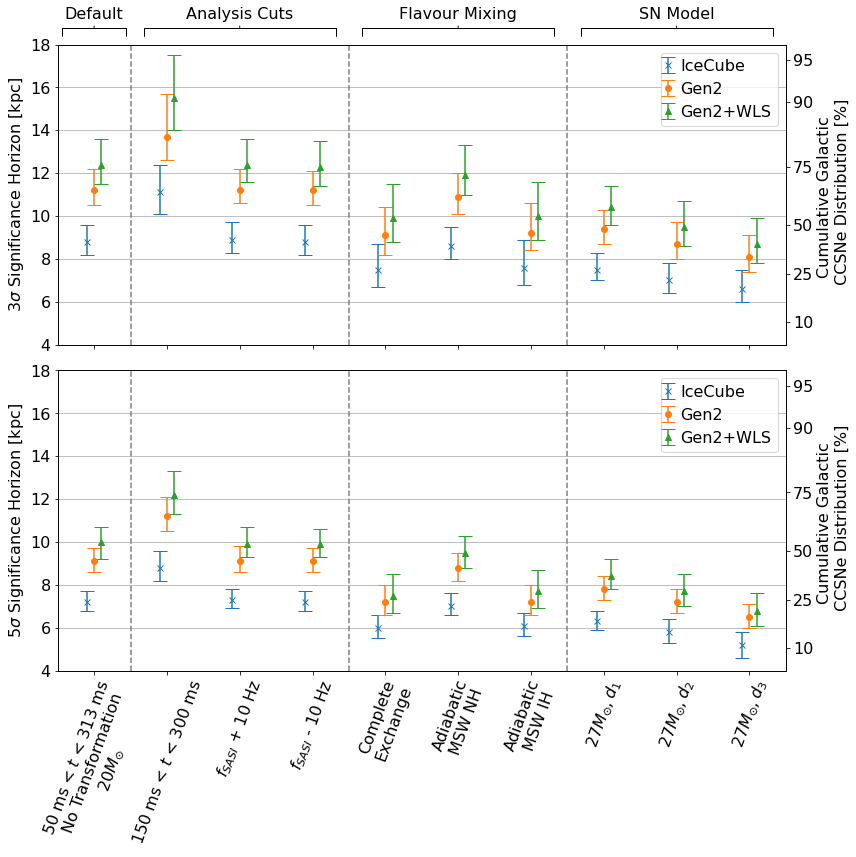

In [20]:
mpl.rcParams['legend.handlelength'] = 0
mpl.rcParams['legend.markerscale'] = 1

fig, ax = plt.subplots(2,1, figsize = (12,12), sharex = True)
xlabels = ['50 ms < $t$ < 313 ms\nNo Transformation\n$20 M_{\odot}$', r'150 ms < $t$ < 300 ms', '$f_{SASI}$ + 10 Hz', '$f_{SASI}$ - 10 Hz',
           'Complete\nExchange', 'Adiabatic\nMSW NH', 'Adiabatic\nMSW IH', 
           r'$27 M_{\odot}, d_1$', r'$27 M_{\odot}, d_2$', r'$27 M_{\odot}, d_3$']


ax[0].errorbar(x=-0.1, y=vanilla_ic86[0][0], yerr=vanilla_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[0].errorbar(x=0, y=vanilla_gen2[0][0], yerr=vanilla_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[0].errorbar(x=0.1, y=vanilla_wls[0][0], yerr=vanilla_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[0].axvline(0.5, color = 'grey', ls = '--')

ax[0].errorbar(x=0.9, y=timewid_ic86[0][0], yerr=timewid_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[0].errorbar(x=1, y=timewid_gen2[0][0], yerr=timewid_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[0].errorbar(x=1.1, y=timewid_wls[0][0], yerr=timewid_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[0].errorbar(x=1.9, y=freqplus_ic86[0][0], yerr=freqplus_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[0].errorbar(x=2, y=freqplus_gen2[0][0], yerr=freqplus_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[0].errorbar(x=2.1, y=freqplus_wls[0][0], yerr=freqplus_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[0].errorbar(x=2.9, y=freqminus_ic86[0][0], yerr=freqminus_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[0].errorbar(x=3, y=freqminus_gen2[0][0], yerr=freqminus_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[0].errorbar(x=3.1, y=freqminus_wls[0][0], yerr=freqminus_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[0].axvline(3.5, color = 'grey', ls = '--')

ax[0].errorbar(x=3.9, y=compex_ic86[0][0], yerr=compex_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[0].errorbar(x=4, y=compex_gen2[0][0], yerr=compex_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[0].errorbar(x=4.1, y=compex_wls[0][0], yerr=compex_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[0].errorbar(x=4.9, y=mswnh_ic86[0][0], yerr=mswnh_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[0].errorbar(x=5, y=mswnh_gen2[0][0], yerr=mswnh_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[0].errorbar(x=5.1, y=mswnh_wls[0][0], yerr=mswnh_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[0].errorbar(x=5.9, y=mswih_ic86[0][0], yerr=mswih_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[0].errorbar(x=6, y=mswih_gen2[0][0], yerr=mswih_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[0].errorbar(x=6.1, y=mswih_wls[0][0], yerr=mswih_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[0].axvline(6.5, color = 'grey', ls = '--')

ax[0].errorbar(x=6.9, y=m27d1_ic86[0][0], yerr=m27d1_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[0].errorbar(x=7, y=m27d1_gen2[0][0], yerr=m27d1_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[0].errorbar(x=7.1, y=m27d1_wls[0][0], yerr=m27d1_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[0].errorbar(x=7.9, y=m27d2_ic86[0][0], yerr=m27d2_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[0].errorbar(x=8, y=m27d2_gen2[0][0], yerr=m27d2_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[0].errorbar(x=8.1, y=m27d2_wls[0][0], yerr=m27d2_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[0].errorbar(x=8.9, y=m27d3_ic86[0][0], yerr=m27d3_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[0].errorbar(x=9, y=m27d3_gen2[0][0], yerr=m27d3_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[0].errorbar(x=9.1, y=m27d3_wls[0][0], yerr=m27d3_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[0].errorbar(x=-1, y=vanilla_ic86[0][0], yerr=vanilla_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0', label = 'IceCube')
ax[0].errorbar(x=-1, y=vanilla_gen2[0][0], yerr=vanilla_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1', label = 'Gen2')
ax[0].errorbar(x=-1, y=vanilla_wls[0][0], yerr=vanilla_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2', label = 'Gen2+WLS')


ax[0].tick_params(labelsize = 16)
ax[0].grid(axis='y')
ax[0].set_xticks(np.arange(10), labels = xlabels, rotation = 70, fontsize = 16, visible = False)
ax[0].set_xlim(-0.5,9.5)
ax[0].set_ylim(4,18)
ax[0].set_ylabel(r'$3\sigma$ Significance Horizon [kpc]', fontsize=16)
ax[0].legend(loc = 'upper right', fontsize=16)

rates = np.array([0.1,0.25,0.5,0.75,0.9,0.95])
ax21 = ax[0].twinx()
ax21.set_ylim(ax[0].get_ylim())
ax21.set_yticks(inv_cdf(rates).flatten())
ax21.set_yticklabels((rates*100).astype(dtype=int), rotation = 0, fontsize = 16)
ax21.set_ylabel('Cumulative Galactic \n CCSNe Distribution [%]', fontsize = 16)

ax[0].annotate('Default', xy=(0.05, 1.05), xytext=(0.05, 1.1), xycoords='axes fraction', 
            fontsize=16, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=2, lengthB=0.5', lw=1.0, color='k'))

ax[0].annotate('Analysis Cuts', xy=(0.25, 1.05), xytext=(0.25, 1.1), xycoords='axes fraction', 
            fontsize=16, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=6, lengthB=0.5', lw=1.0, color='k'))

ax[0].annotate('Flavour Mixing', xy=(0.55, 1.05), xytext=(0.55, 1.1), xycoords='axes fraction', 
            fontsize=16, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=6, lengthB=0.5', lw=1.0, color='k'))

ax[0].annotate('SN Model', xy=(0.85, 1.05), xytext=(0.85, 1.1), xycoords='axes fraction', 
            fontsize=16, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=6, lengthB=0.5', lw=1.0, color='k'))


ax[1].errorbar(x=-0.1, y=vanilla_ic86[1][0], yerr=vanilla_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[1].errorbar(x=0, y=vanilla_gen2[1][0], yerr=vanilla_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[1].errorbar(x=0.1, y=vanilla_wls[1][0], yerr=vanilla_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[1].axvline(0.5, color = 'grey', ls = '--')

ax[1].errorbar(x=0.9, y=timewid_ic86[1][0], yerr=timewid_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[1].errorbar(x=1, y=timewid_gen2[1][0], yerr=timewid_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[1].errorbar(x=1.1, y=timewid_wls[1][0], yerr=timewid_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[1].errorbar(x=1.9, y=freqplus_ic86[1][0], yerr=freqplus_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[1].errorbar(x=2, y=freqplus_gen2[1][0], yerr=freqplus_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[1].errorbar(x=2.1, y=freqplus_wls[1][0], yerr=freqplus_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[1].errorbar(x=2.9, y=freqminus_ic86[1][0], yerr=freqminus_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[1].errorbar(x=3, y=freqminus_gen2[1][0], yerr=freqminus_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[1].errorbar(x=3.1, y=freqminus_wls[1][0], yerr=freqminus_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[1].axvline(3.5, color = 'grey', ls = '--')

ax[1].errorbar(x=3.9, y=compex_ic86[1][0], yerr=compex_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[1].errorbar(x=4, y=compex_gen2[1][0], yerr=compex_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[1].errorbar(x=4.1, y=compex_wls[1][0], yerr=compex_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[1].errorbar(x=4.9, y=mswnh_ic86[1][0], yerr=mswnh_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[1].errorbar(x=5, y=mswnh_gen2[1][0], yerr=mswnh_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[1].errorbar(x=5.1, y=mswnh_wls[1][0], yerr=mswnh_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[1].errorbar(x=5.9, y=mswih_ic86[1][0], yerr=mswih_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[1].errorbar(x=6, y=mswih_gen2[1][0], yerr=mswih_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[1].errorbar(x=6.1, y=mswih_wls[1][0], yerr=mswih_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[1].axvline(6.5, color = 'grey', ls = '--')

ax[1].errorbar(x=6.9, y=m27d1_ic86[1][0], yerr=m27d1_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[1].errorbar(x=7, y=m27d1_gen2[1][0], yerr=m27d1_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[1].errorbar(x=7.1, y=m27d1_wls[1][0], yerr=m27d1_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[1].errorbar(x=7.9, y=m27d2_ic86[1][0], yerr=m27d2_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[1].errorbar(x=8, y=m27d2_gen2[1][0], yerr=m27d2_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[1].errorbar(x=8.1, y=m27d2_wls[1][0], yerr=m27d2_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[1].errorbar(x=8.9, y=m27d3_ic86[1][0], yerr=m27d3_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[1].errorbar(x=9, y=m27d3_gen2[1][0], yerr=m27d3_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[1].errorbar(x=9.1, y=m27d3_wls[1][0], yerr=m27d3_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[1].errorbar(x=-1, y=vanilla_ic86[1][0], yerr=vanilla_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0', label = 'IceCube')
ax[1].errorbar(x=-1, y=vanilla_gen2[1][0], yerr=vanilla_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1', label = 'Gen2')
ax[1].errorbar(x=-1, y=vanilla_wls[1][0], yerr=vanilla_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2', label = 'Gen2+WLS')


ax[1].tick_params(labelsize = 16)
ax[1].grid(axis='y')
ax[1].set_xticks(np.arange(10), labels = xlabels, rotation = 70, fontsize = 16)
ax[1].set_xlim(-0.5,9.5)
ax[1].set_ylim(4,18)

ax[1].set_ylabel(r'$5\sigma$ Significance Horizon [kpc]', fontsize=16)
ax[1].legend(loc = 'upper right', fontsize=16)

rates = np.array([0.1,0.25,0.5,0.75,0.9,0.95])
ax22 = ax[1].twinx()
ax22.set_ylim(ax[1].get_ylim())
ax22.set_yticks(inv_cdf(rates).flatten())
ax22.set_yticklabels((rates*100).astype(dtype=int), rotation = 0, fontsize = 16)
ax22.set_ylabel('Cumulative Galactic \n CCSNe Distribution [%]', fontsize = 16)

plt.tight_layout()
plt.savefig('../plots/ftf_ampl_all_3+5sigma.pdf', dpi = 200)